In [25]:
import urllib.request
from basic import create_dataloader_v1
from GPT_architecture import GPTModel
from ch5 import GPT_CONFIG_124M, generate, text_to_token_ids, token_ids_to_txt, calc_loss_loader
import torch
import tiktoken
import numpy as np

In [2]:
def assign(left, right):
    if left is not None:
        if left.shape != right.shape:
            raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
        return torch.nn.Parameter(torch.tensor(right))
    else:
        # If left is None (e.g., bias=None), create a new Parameter
        return torch.nn.Parameter(torch.tensor(right))


In [15]:
def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        # Map Query, Key and Value weights
        q_w, k_w, v_w = np.split(params["blocks"][b]["attn"]["c_attn"]["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight   = assign(gpt.trf_blocks[b].att.W_key.weight,   k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        # Map Query, Key and Value biases
        q_b, k_b, v_b = np.split(params["blocks"][b]["attn"]["c_attn"]["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(gpt.trf_blocks[b].att.W_query.bias, q_b.T)
        gpt.trf_blocks[b].att.W_key.bias   = assign(gpt.trf_blocks[b].att.W_key.bias,   k_b.T)
        gpt.trf_blocks[b].att.W_value.bias = assign(gpt.trf_blocks[b].att.W_value.bias, v_b.T)

        # Attention output projection
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"]
        )

        # Feedforward
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"]
        )
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"]
        )

        gpt.trf_blocks[b].norm1.gamma = assign(gpt.trf_blocks[b].norm1.gamma, params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.beta  = assign(gpt.trf_blocks[b].norm1.beta,  params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.gamma = assign(gpt.trf_blocks[b].norm2.gamma, params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.beta  = assign(gpt.trf_blocks[b].norm2.beta,  params["blocks"][b]["ln_2"]["b"])

    # Final norm
    gpt.final_norm.gamma = assign(gpt.final_norm.gamma, params["g"])
    gpt.final_norm.beta  = assign(gpt.final_norm.beta,  params["b"])


    # Output head
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


In [26]:
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe
Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
Token embedding weight tensor dimensions: (50257, 768)
Output text:
 Every effort moves you where the power lies."

He added he didn't plan for his political opponents to support him now and then.

Epoch 1: Train loss = 3.6220, Val loss = 3.4699
Epoch 2: Train loss = 3.6220, Val loss = 3.4699
Epoch 3: Train loss = 3.6220, Val loss = 3.4699
Epoch 4: Train loss = 3.6220, Val loss = 3.

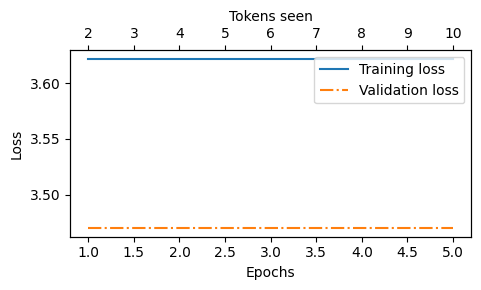

In [29]:
def main():
    torch.manual_seed(123)
    device = torch.device("cpu")  # or "cuda" if available

    # Download GPT-2 weights
    url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py"
    filename = url.split('/')[-1]
    urllib.request.urlretrieve(url, filename)

    from gpt_download import download_and_load_gpt2
    settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

    print("Settings:", settings)
    print("Parameter dictionary keys:", params.keys())
    print("Token embedding weight tensor dimensions:", params["wte"].shape)

    # Model configuration
    model_configs = {
        "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
        "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
        "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
        "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
    }

    model_name = "gpt2-small (124M)"
    NEW_CONFIG = GPT_CONFIG_124M.copy()
    NEW_CONFIG.update(model_configs[model_name])
    NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

    # Initialize model
    gpt = GPTModel(NEW_CONFIG)
    gpt.eval()
    load_weights_into_gpt(gpt, params)
    gpt.to(device)

    # Generate example text
    prompt = "Every effort moves you"
    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids(prompt, tiktoken.get_encoding("gpt2")).to(device),
        max_new_tokens=25,
        context_size=NEW_CONFIG["context_length"],
        top_k=50,
        temperature=1.5
    )
    print("Output text:\n", token_ids_to_txt(token_ids, tiktoken.get_encoding("gpt2")))

    # Load dataset
    file_path = "the-verdict.txt"
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

    split_idx = int(0.5 * len(text_data))
    train_data, val_data = text_data[:split_idx], text_data[split_idx:]

    # Create dataloaders
    train_loader = create_dataloader_v1(
        train_data, batch=2, max_len=NEW_CONFIG["context_length"],
        stride=NEW_CONFIG["context_length"], drop_last=True,
        shuffle=True, num_workers=0
    )
    val_loader = create_dataloader_v1(
        val_data, batch=2, max_len=NEW_CONFIG["context_length"],
        stride=NEW_CONFIG["context_length"], drop_last=False,
        shuffle=False, num_workers=0
    )

    # Compute losses over epochs
    num_epochs = 5  # adjust as needed
    train_losses = []
    val_losses = []
    tokens_seen = []

    for epoch in range(1, num_epochs + 1):
        with torch.no_grad():
            train_loss = calc_loss_loader(train_loader, gpt, device)
            val_loss = calc_loss_loader(val_loader, gpt, device)

        train_losses.append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        val_losses.append(val_loss.item() if isinstance(val_loss, torch.Tensor) else val_loss)
        tokens_seen.append(len(train_loader.dataset) * epoch)

        print(f"Epoch {epoch}: Train loss = {train_losses[-1]:.4f}, Val loss = {val_losses[-1]:.4f}")

    # Plot the losses
    plot_losses(list(range(1, num_epochs + 1)), tokens_seen, train_losses, val_losses)


if __name__ == "__main__":
    main()